In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')
np.__version__


2023-10-29 03:49:00.033893: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 03:49:00.076251: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 03:49:00.315094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 03:49:00.315221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 03:49:00.315924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

'1.24.3'

In [4]:
df = pd.read_csv('./psychometric.csv')
for col in df.columns:
    df[col] = df[col].map(lambda x : x.lower())
df = df.sample(frac=1.0)

df['Role'] = (df['Role'] == 'sales').astype(np.int32)
df = df.sample(frac=1.0)

for i in range(1, 6):
    df[f'Q{i}'] = df[f'Q{i}'].map(lambda x : f'<start{i}> {x} </end{i}>')

df

,Q1,Q2,Q3,Q4,Q5,Role
6,<start1> proactively initiating conversations ...,<start2> rejection is an opportunity for self-...,<start3> to maintain creativity and organizati...,"<start4> i made sure the group felt heard, off...",<start5> i'll be an adaptable and proactive te...,1
71,<start1> i often find creative inspiration whe...,<start2> i'm known to be persistent and adapti...,<start3> i stay inspired by exploring unconven...,<start4> i emphasized the innovation and poten...,"<start5> i'd respect team members' expertise, ...",0
86,<start1> i'm comfortable when others take the ...,<start2> rejection in it prompts me to persist...,<start3> creativity flourishes under pressure....,<start4> my approach was to use plain language...,"<start5> i'd be attentive, support my team's g...",0
88,<start1> i'm more of a listener in social situ...,"<start2> in it, rejection inspires me to persi...",<start3> i maintain a structured approach with...,<start4> i shared my proposal by simplifying t...,<start5> steering a cross-functional team succ...,0
7,"<start1> in social situations, i enjoy approac...",<start2> i view rejection as feedback. i persi...,<start3> creativity is enhanced through contin...,"<start4> i maintained eye contact, conveyed en...",<start5> i'm excited to collaborate closely wi...,1
...,...,...,...,...,...,...
62,<start1> i often find creative inspiration whe...,<start2> i'd approach rejection as a challenge...,<start3> i use tight deadlines as a chance to ...,<start4> i explained my idea using everyday co...,"<start5> i'd work alongside the team, adhere t...",1
50,<start1> i'm more comfortable when others init...,<start2> i'd view rejection as a chance to enh...,<start3> i stay organized using comprehensive ...,<start4> i started with a relatable analogy to...,"<start5> i'd work in sync with the team, meet ...",1
70,<start1> i'm comfortable with both being appro...,<start2> rejection or failure is part of the i...,<start3> tight deadlines spark my technical cr...,<start4> i shared relevant technical research ...,"<start5> i'd stay organized, document my work,...",0
42,<start1> i thrive in initiating conversations....,<start2> rejection pushes me to keep evolving ...,<start3> i draw inspiration from the sense of ...,<start4> i tailored my presentation to the gro...,"<start5> i'll bring my best to the team, activ...",1


In [5]:
df.loc[0].values[:-1]

array(["<start1> i excel at initiating conversations, a key part of my role. it's essential for building rapport and understanding clients, helping me connect and identify opportunities effectively. </end1>",
       '<start2> rejection pushes me to improve. i persist, adapt, and stay committed to finding the best path to success. </end2>',
       '<start3> tight deadlines serve as a reminder of the difference my work can make. i stay organized with time blocks and tap into my creative problem-solving skills. </end3>',
       '<start4> i presented my proposal by opening with a captivating story that engaged the audience emotionally. i focused on how the idea would benefit them personally. </end4>',
       "<start5> i'll collaborate closely with team members, share my ideas, and support their efforts to reach our goal. i'll stay open to learning from experienced colleagues and adapt to the team's needs. </end5>"],
      dtype=object)

In [6]:
# X = []

# for i in range(len(df)):
#     x = ""
#     for j in range(6):
#         x += f"<start{j}> {df.iloc[i, j]} <end{j}> "
#     X.append(x)

# X[0]

X = []
y = []

for i in range(len(df)):
    X.extend(df.loc[i].values[:-1])
    y.extend([df.loc[i].values[-1]] * 5)



In [7]:
# X, y = df['Description'].values, df['Outcome'].values

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 1296


In [8]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
# train_x.shape, val_x.shape, train_y.shape, val_y.shape

<Axes: ylabel='Count'>

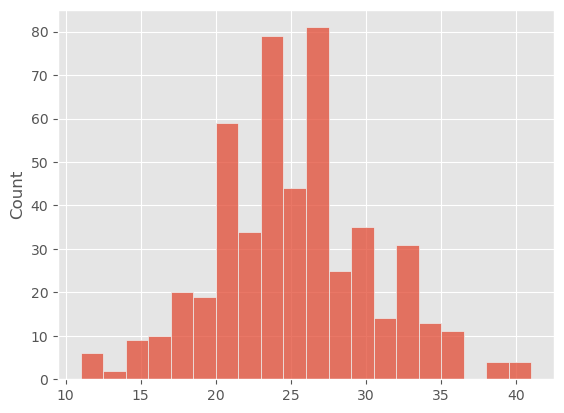

In [9]:
lens = []
for x in X:
    lens.append(len(x.split(' ')))

sea.histplot(lens)

In [10]:
from transformers import AutoTokenizer
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(train_x), max_length = 40, padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), max_length = 40, padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)



2023-10-29 03:49:56.230472: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
num_classes = 2

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = num_classes,
    id2label = {1:'Good', 0:"Bad"},
    label2id = {"Good":1, 'Bad':0},
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 1e-5),
    metrics = ['accuracy'])

model

RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
No module named 'keras.engine'

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)



: 

In [ ]:
EPOCHS = 10

history = model.fit(train_dataset,
          epochs = EPOCHS,
          validation_data = val_dataset)

: 

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)
pred1 = pipe("<start1>I excel at initiating conversations, a key part of my role. It's essential for building rapport and understanding clients, helping me connect and identify opportunities effectively.</end1>")

print(pred1[0][:2])

: 

In [ ]:
input = ["I excel in technology but am reluctant to seek help or collaborate. My ego is my guiding force, overshadowing any potential for growth through collective efforts"]

input_ids = tokenizer.encode(input[0], add_special_tokens=True, max_length=60, padding='max_length', return_tensors='tf')

# test_dataset = tf.data.Dataset.from_tensor_slices((
    # dict(tokenizer(input, padding="max_length", truncation=True, max_length=40)),
# )).batch(1)


: 

In [ ]:
outputs = model(input_ids)
pred = outputs[0]

tf.math.exp(pred)/tf.reduce_sum(tf.math.exp(pred))


: 

In [ ]:

for head in range(0, 12):
    sum_attention_scores = tf.reduce_sum(outputs[1][0][0][head], axis=-1)
    max_attention_token_index = tf.math.argmax(sum_attention_scores)

    # for token in max_attention_token_index[:5]:
    word = tokenizer.convert_ids_to_tokens([input_ids[0][max_attention_token_index]])
    print(word)

# print("Token with maximum summed attention:", max_attention_token, max_attention_token_index)


: 

: 